In [1]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu

In [2]:
def find_significant_areas(dictionary, experimental_groups, value, test='mannwhitneyu', alpha=0.05):
    dfs = \
    ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                                  dict_results_across_mice=dictionary, 
                                  value=value)
    df_ttest = ace.test_across_groups(dfs,
                                     test=test,
                                     groups=list(experimental_groups.keys()))
    # sort dataframe pvalues of control vs fam and pick the first 20
    columns = df_ttest.loc[:, df_ttest.columns!='area'].columns
    df_sigareas = pd.DataFrame()
    for col in columns:
        df = df_ttest.sort_values(by=col)[['area', col]]
        df_sigareas = pd.concat([df_sigareas, df[df[col]<alpha]['area'].reset_index(drop=True)], axis=1)
    df_sigareas.columns = [col.replace('pval_', '') for col in columns]
    return df_sigareas

# WILD WITH FATHER

In [3]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'WILD_with_father'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subjects = [name for name in os.listdir(data_directory) \
                if os.path.isdir(os.path.join(data_directory, name))]

In [4]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [5]:
def load_subject(subject):
    if subject == 'W8Fam':
        df_mouse = pd.read_csv(data_directory + subject + '/cells1000.csv')  
    else:
        df_mouse = pd.read_csv(data_directory + subject + '/cells2500.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    return df_mouse

In [6]:
# # NB: Run only if file does not exist or needs to be regenerated
# dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject), 
#                                                                           vol=volumes, 
#                                                                           level=8) for subject in subjects}
# np.save('dict_results/newvolumes/dict_results_across_mice_WILD_with_father2500_newwild.npy', dict_results_across_mice)

In [7]:
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_WILD_with_father2500_newwild.npy', 
                                   allow_pickle=True).item()

In [8]:
# remove unclean data
experimental_groups = utils.divide_in_exp_groups(list_subjects=list(dict_results_across_mice.keys()))

In [9]:
# dict_results_across_mice = np.load('dict_results/dict_results_across_mice_WILD_without_father2500.npy', 
#                                    allow_pickle=True).item()

In [10]:
subjects = list(dict_results_across_mice.keys())

In [11]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)


## Calculate number of cells

In [12]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [124]:
df_control_cell_count.set_index('area').sum()

W10Control    12128
W38Control    33014
W26Control    14219
W15Control    26607
W31Control    40416
W23Control    16849
W7Control     18122
W29Control    28858
W3Control     29800
W17Control    20326
dtype: int64

In [125]:
df_fam_cell_count.set_index('area').sum()

W14Fam    19904
W16Fam    28807
W25Fam    32747
W5Fam     15205
W40Fam    18653
W36Fam    36035
W8Fam     24934
W34Fam    20919
dtype: int64

In [126]:
df_unfam_cell_count.set_index('area').sum()

W27Unfam    30535
W20Unfam    17892
W2Unfam     35149
W11Unfam    29467
W13Unfam    39879
W18Unfam    29761
W21Unfam    12544
dtype: int64

In [127]:
df_ttest_ncells = ace.test_across_groups([df_control_cell_count,df_fam_cell_count,df_unfam_cell_count],
                                        test='mannwhitneyu')
df_ttest_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.394639,0.262677,0.261667
1,Primary motor area,0.25258,0.403625,0.225957
2,Secondary motor area,0.446987,0.152754,0.301262
3,Primary somatosensory area,0.482282,0.152754,0.192709
4,Supplemental somatosensory area,0.377907,0.203407,0.301262
...,...,...,...,...
194,Interfascicular nucleus raphe,0.339869,0.342436,0.154597
195,Interpeduncular nucleus,0.411792,0.460986,0.385971
196,Rostral linear nucleus raphe,0.355436,0.432,0.473976
197,Central linear nucleus raphe,0.148862,0.439561,0.279831


In [128]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [136]:
find_significant_areas(dictionary=dict_results_across_mice, 
                       experimental_groups=experimental_groups,
                       value='n_cells',
                       test='mannwhitneyu',
                      alpha=0.05)

,Control_vs_Fam,Control_vs_Unfam,Fam_vs_Unfam
0,Posterior amygdalar nucleus,Cortical amygdalar area,Septofimbrial nucleus
1,Triangular nucleus of septum,Medial amygdalar nucleus,Triangular nucleus of septum
2,Ammon's horn,Posterior amygdalar nucleus,Paraventricular hypothalamic nucleus descendin...
3,Septofimbrial nucleus,Ventral premammillary nucleus,Postpiriform transition area
4,Cortical amygdalar area,Postpiriform transition area,Anterior olfactory nucleus
5,Ventral part of the lateral geniculate complex,Piriform-amygdalar area,Ammon's horn
6,Paraventricular hypothalamic nucleus descendin...,Piriform area,NaN
7,Lateral visual area,Nucleus sagulum,NaN
8,Medial amygdalar nucleus,Tuberomammillary nucleus,NaN
9,Tuberal nucleus,Intercalated amygdalar nucleus,NaN


In [130]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Posterior amygdalar nucleus,0.000587697
Triangular nucleus of septum,0.00667539
Ammon's horn,0.00727401
Septofimbrial nucleus,0.00918091
Cortical amygdalar area,0.0147447
Ventral part of the lateral geniculate complex,0.0249493
Paraventricular hypothalamic nucleus descending division,0.0265301
Lateral visual area,0.0280457
Medial amygdalar nucleus,0.0280457


In [131]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Cortical amygdalar area,0.00199529
Medial amygdalar nucleus,0.00199529
Posterior amygdalar nucleus,0.00265044
Ventral premammillary nucleus,0.00360463
Postpiriform transition area,0.00364035
Piriform-amygdalar area,0.0109135
Piriform area,0.014054
Nucleus sagulum,0.0248432
Tuberomammillary nucleus,0.028064


In [132]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Septofimbrial nucleus,0.0117003
Triangular nucleus of septum,0.0158312
Paraventricular hypothalamic nucleus descending division,0.0181988
Postpiriform transition area,0.0244693
Anterior olfactory nucleus,0.0364244
Ammon's horn,0.0466688
Anteromedial visual area,0.0587775
Subiculum,0.0591061
Substantia nigra reticular part,0.0591061


## Calculate corr matrices on number of cells

In [23]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

Text(0.5, 1.0, 'CONTROL')

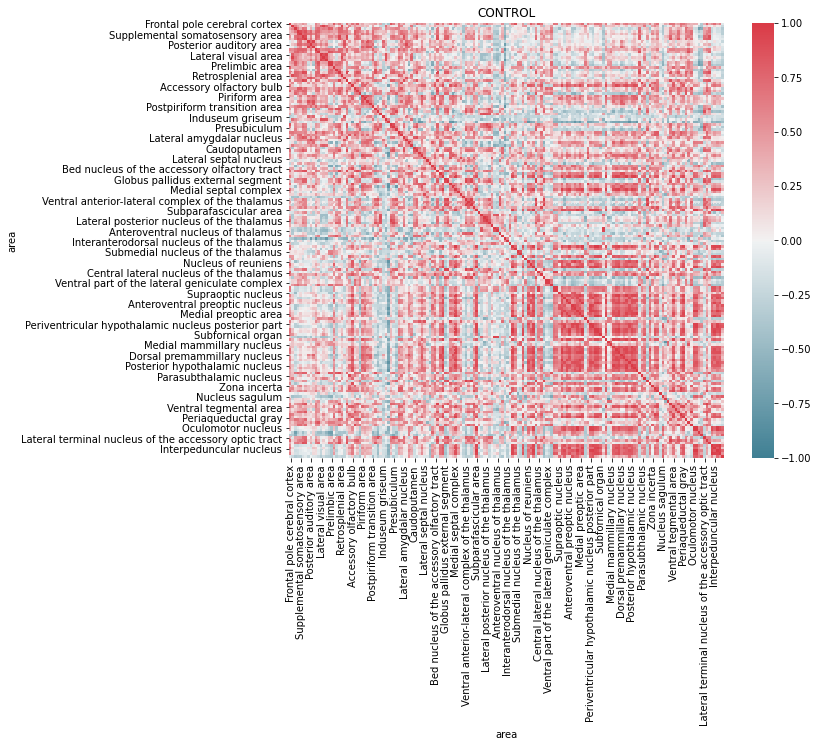

In [24]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

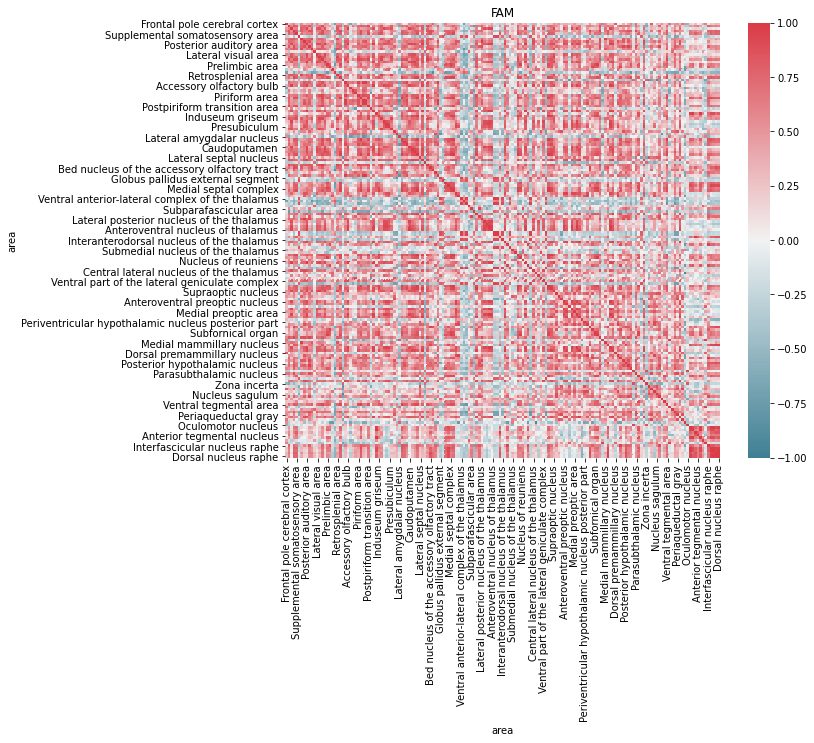

In [25]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

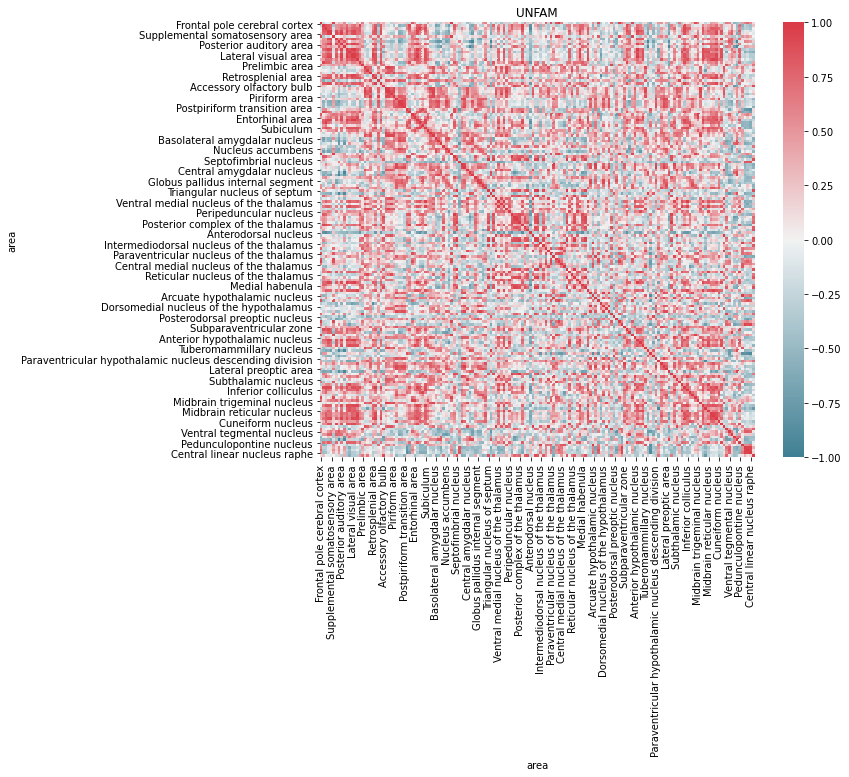

In [26]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

In [27]:
df_control_rd, df_fam_rd, df_unfam_rd = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='relative_density')
df_ttest_rd = ace.test_across_groups([df_control_rd,df_fam_rd,df_unfam_rd])
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_rd = df_ttest_rd.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [28]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_rd.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Posterior amygdalar nucleus,3.28296e-05
Septofimbrial nucleus,0.00726818
Cortical amygdalar area,0.0112273
Central amygdalar nucleus,0.0158225
Medial amygdalar nucleus,0.016506
Triangular nucleus of septum,0.0304182
Paraventricular hypothalamic nucleus descending division,0.0331939
Accessory olfactory bulb,0.0401367
Main olfactory bulb,0.0485828


In [29]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_rd.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Cortical amygdalar area,0.00172424
Posterior amygdalar nucleus,0.00186138
Piriform area,0.00324586
Medial amygdalar nucleus,0.00544365
Postpiriform transition area,0.00881984
Piriform-amygdalar area,0.0173514
Claustrum,0.0391874
Main olfactory bulb,0.0518711
Ventral premammillary nucleus,0.0534543


## Histograms with father

<AxesSubplot:xlabel='area', ylabel='number of cells'>

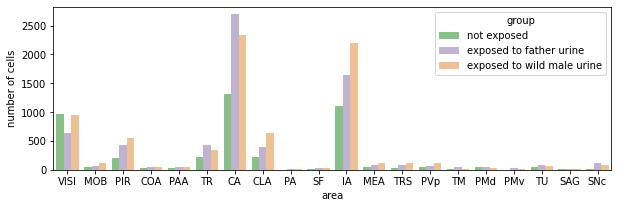

In [30]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_Control_vs_Fam']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_Control_vs_Unfam']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_Fam_vs_Unfam']<0.05]['area'].values]))

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'number of cells', 'group'])
fam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
unfam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['not exposed' for area in areas_ttest]
control['number of cells'] = [df_control_cell_count.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['exposed to father urine' for area in areas_ttest]
fam['number of cells'] = [df_fam_cell_count.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['exposed to wild male urine' for area in areas_ttest]
unfam['number of cells'] = [df_unfam_cell_count.set_index('area').loc[area].mean() for area in areas_ttest]
with_father = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,3), sharey=True)
sns.barplot(
    data=with_father,
    x="area", y="number of cells", hue="group", palette="Accent", ax=ax)

<AxesSubplot:xlabel='area', ylabel='energy'>

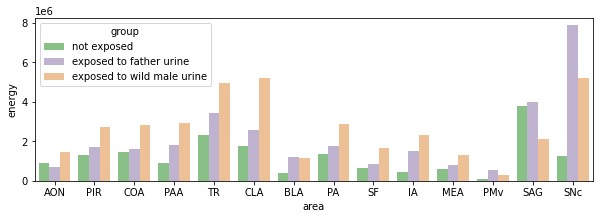

In [31]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')
df_ttest_energy = ace.test_across_groups([df_control_energy,df_fam_energy,df_unfam_energy])
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_Control_vs_Fam']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_Control_vs_Unfam']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_Fam_vs_Unfam']<0.05]['area'].values]))

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'energy', 'group'])
fam = pd.DataFrame(columns=['area', 'energy', 'group'])
unfam = pd.DataFrame(columns=['area', 'energy', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['not exposed' for area in areas_ttest]
control['energy'] = [df_control_energy.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['exposed to father urine' for area in areas_ttest]
fam['energy'] = [df_fam_energy.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['exposed to wild male urine' for area in areas_ttest]
unfam['energy'] = [df_unfam_energy.set_index('area').loc[area].mean() for area in areas_ttest]
with_father = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,3), sharey=True)
sns.barplot(
    data=with_father,
    x="area", y="energy", hue="group", palette="Accent", ax=ax)

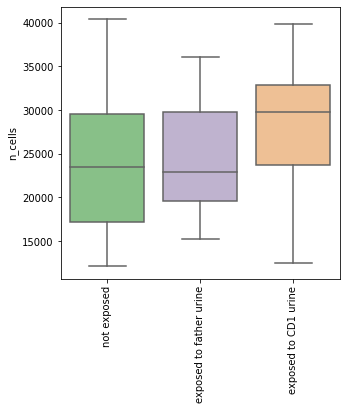

In [13]:
# stack1
subjects = subjects

control = pd.DataFrame(columns=['subject', 'n_cells', 'group'])
fam = pd.DataFrame(columns=['subject', 'n_cells', 'group'])
unfam = pd.DataFrame(columns=['subject', 'n_cells', 'group'])
control['subject'] = [s for s in experimental_groups['Control']]
control['group'] = ['not exposed' for s in experimental_groups['Control']]
control['n_cells'] = [df_control_cell_count.set_index('area').sum()[s] for s in experimental_groups['Control']]

fam['subject'] = [s for s in experimental_groups['Fam']]
fam['group'] = ['exposed to father urine' for s in experimental_groups['Fam']]
fam['n_cells'] = [df_fam_cell_count.set_index('area').sum()[s] for s in experimental_groups['Fam']]

unfam['subject'] = [s for s in experimental_groups['Unfam']]
unfam['group'] = ['exposed to CD1 urine'  for s in experimental_groups['Unfam']]
unfam['n_cells'] = [df_unfam_cell_count.set_index('area').sum()[s] for s in experimental_groups['Unfam']]
with_father = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5), sharey=True)
sns.boxplot(
    data=with_father,
    x="group", y="n_cells", palette="Accent", ax=ax)
ax.set_xlabel('')
ax.tick_params(axis='x', labelrotation=90)

# WILD without father

In [14]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'WILD_without_father'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subjects = [name for name in os.listdir(data_directory) \
                if os.path.isdir(os.path.join(data_directory, name))]

In [15]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [16]:
# # NB: Run only if file does not exist or needs to be regenerated
# dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject), 
#                                                                           vol=volumes, 
#                                                                           level=8) for subject in subjects}
# np.save('dict_results/newvolumes/dict_results_across_mice_WILD_without_father2500.npy', dict_results_across_mice)

In [17]:
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_WILD_without_father2500.npy', allow_pickle=True).item()

In [18]:
subjects=list(dict_results_across_mice.keys())

In [19]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)


In [20]:
experimental_groups

{'Control': ['W10Control',
  'W38Control',
  'W26Control',
  'W15Control',
  'W31Control',
  'W23Control',
  'W7Control',
  'W29Control',
  'W3Control',
  'W17Control'],
 'Fam': ['W12Fam', 'W9Fam', 'W30Fam', 'W32Fam', 'W1Fam', 'W22Fam'],
 'Unfam': ['W6Unfam',
  'W24Unfam',
  'W35Unfam',
  'W4Unfam',
  'W28Unfam',
  'W39Unfam',
  'W37Unfam']}

# Calculate number of cells

In [21]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [145]:
df_control_cell_count.set_index('area').sum()

W10Control    12128
W38Control    33014
W26Control    14219
W15Control    26607
W31Control    40416
W23Control    16849
W7Control     18122
W29Control    28858
W3Control     29800
W17Control    20326
dtype: int64

In [146]:
df_fam_cell_count.set_index('area').sum()

W12Fam    24813
W9Fam     28103
W30Fam    39350
W32Fam    29027
W1Fam     40106
W22Fam    45559
dtype: int64

In [147]:
df_unfam_cell_count.set_index('area').sum()

W6Unfam     17974
W24Unfam    32843
W35Unfam    81500
W4Unfam     31262
W28Unfam    27061
W39Unfam    35159
W37Unfam    34223
dtype: int64

In [95]:
df1 = df_unfam_cell_count[['W35Unfam']]
df2 = df_unfam_cell_count[['W6Unfam', 'W4Unfam', 'W24Unfam', 'W28Unfam', 'W39Unfam', 'W37Unfam']].mean(axis=1)
df2 = pd.DataFrame(df2, columns=['mean'])
(df1['W35Unfam'] - df2['mean']).describe()

count     198.000000
mean      261.345118
std       814.400583
min     -1431.666667
25%         0.000000
50%        11.833333
75%       207.333333
max      7277.666667
dtype: float64

In [75]:
df_ttest_ncells = ace.test_across_groups([df_control_cell_count,df_fam_cell_count,df_unfam_cell_count],
                                        test='mannwhitneyu')

In [77]:
find_significant_areas(dictionary=dict_results_across_mice, 
                       experimental_groups=experimental_groups,
                       value='n_cells',
                       test='mannwhitneyu',
                      alpha=0.05).to_csv('sig_areas_WILD_without_father.csv')

In [44]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [45]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Primary motor area,0.00283862
Tuberal nucleus,0.00537366
Posterior amygdalar nucleus,0.00537366
Basolateral amygdalar nucleus,0.00733413
Piriform-amygdalar area,0.00985028
Main olfactory bulb,0.00985028
Medial amygdalar nucleus,0.00985028
Cortical amygdalar area,0.0130898
Piriform area,0.0172119


In [46]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Postpiriform transition area,0.000380153
Agranular insular area,0.00199529
Piriform-amygdalar area,0.00270696
Main olfactory bulb,0.00485294
Primary motor area,0.00641335
Secondary motor area,0.0084023
Cortical amygdalar area,0.0109135
Piriform area,0.0109135
Ventral part of the lateral geniculate complex,0.0174355


In [47]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Ventral part of the lateral geniculate complex,0.00896848
Dorsomedial nucleus of the hypothalamus,0.0134046
Anterior tegmental nucleus,0.0244432
Parastrial nucleus,0.0250922
Subgeniculate nucleus,0.0266745
Ventral tegmental area,0.026892
Posterior limiting nucleus of the thalamus,0.0299751
Posterior amygdalar nucleus,0.0314641
Ventral tegmental nucleus,0.0354852


# Calculate corr matrices on number of cells

In [48]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

Text(0.5, 1.0, 'CONTROL')

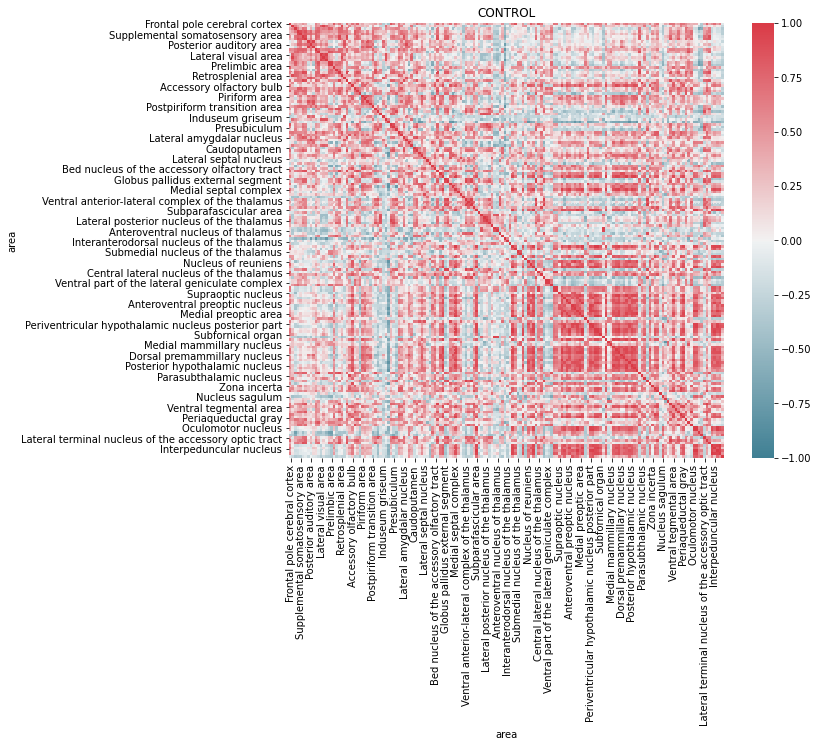

In [49]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

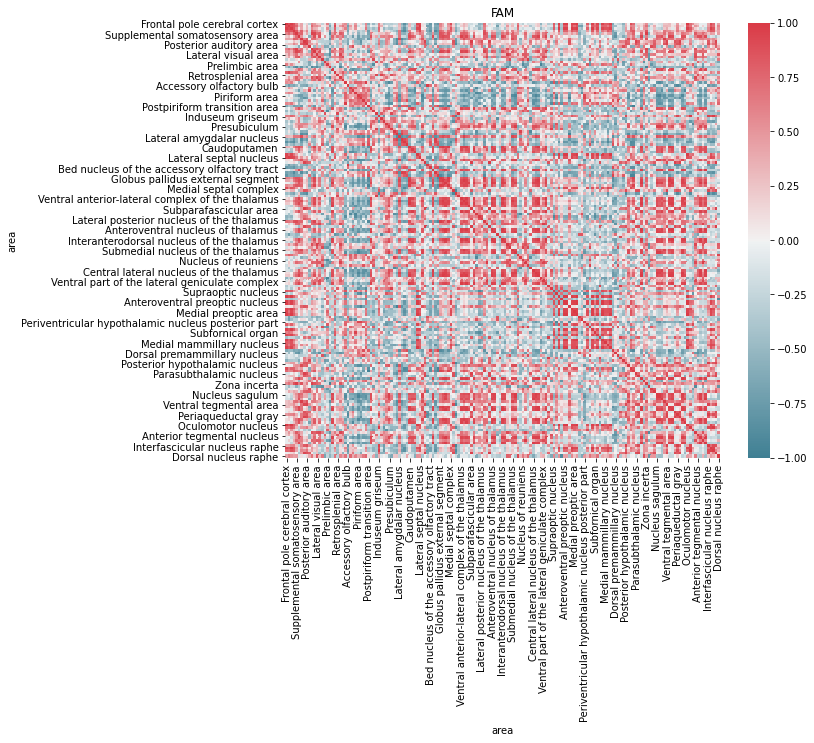

In [50]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

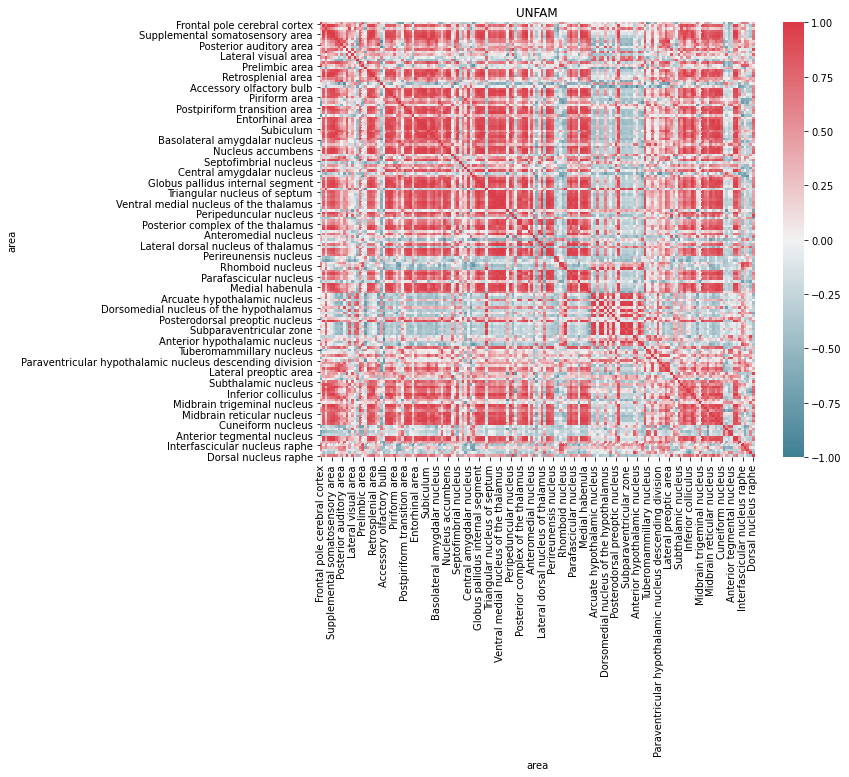

In [51]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

## Histograms WITHOUT FATHER

<AxesSubplot:xlabel='area', ylabel='number of cells'>

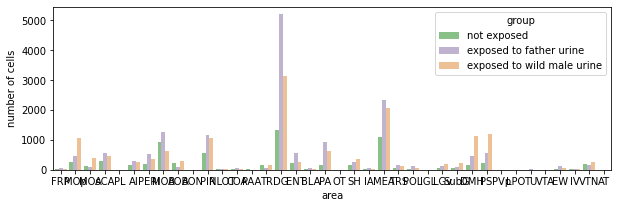

In [52]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_Control_vs_Fam']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_Control_vs_Unfam']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_Fam_vs_Unfam']<0.05]['area'].values]))

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'number of cells', 'group'])
fam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
unfam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['not exposed' for area in areas_ttest]
control['number of cells'] = [df_control_cell_count.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['exposed to father urine' for area in areas_ttest]
fam['number of cells'] = [df_fam_cell_count.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['exposed to wild male urine' for area in areas_ttest]
unfam['number of cells'] = [df_unfam_cell_count.set_index('area').loc[area].mean() for area in areas_ttest]
with_father = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,3), sharey=True)
sns.barplot(
    data=with_father,
    x="area", y="number of cells", hue="group", palette="Accent", ax=ax)

<AxesSubplot:xlabel='area', ylabel='energy'>

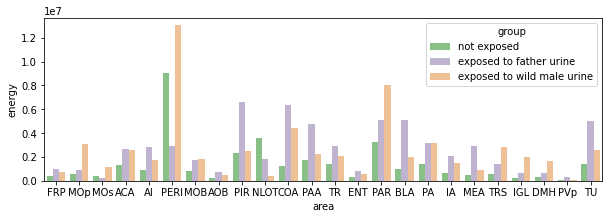

In [53]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')
df_ttest_energy = ace.test_across_groups([df_control_energy,df_fam_energy,df_unfam_energy])
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_Control_vs_Fam']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_Control_vs_Unfam']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_Fam_vs_Unfam']<0.05]['area'].values]))

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'energy', 'group'])
fam = pd.DataFrame(columns=['area', 'energy', 'group'])
unfam = pd.DataFrame(columns=['area', 'energy', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['not exposed' for area in areas_ttest]
control['energy'] = [df_control_energy.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['exposed to father urine' for area in areas_ttest]
fam['energy'] = [df_fam_energy.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['exposed to wild male urine' for area in areas_ttest]
unfam['energy'] = [df_unfam_energy.set_index('area').loc[area].mean() for area in areas_ttest]
with_father = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(10,3), sharey=True)
sns.barplot(
    data=with_father,
    x="area", y="energy", hue="group", palette="Accent", ax=ax)

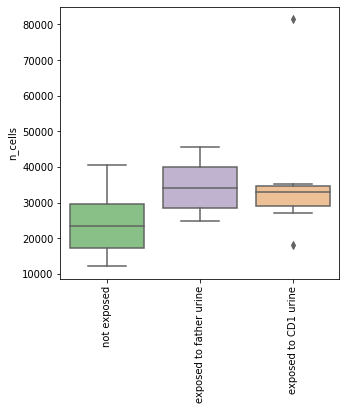

In [22]:
# stack1
subjects = subjects

control = pd.DataFrame(columns=['subject', 'n_cells', 'group'])
fam = pd.DataFrame(columns=['subject', 'n_cells', 'group'])
unfam = pd.DataFrame(columns=['subject', 'n_cells', 'group'])
control['subject'] = [s for s in experimental_groups['Control']]
control['group'] = ['not exposed' for s in experimental_groups['Control']]
control['n_cells'] = [df_control_cell_count.set_index('area').sum()[s] for s in experimental_groups['Control']]

fam['subject'] = [s for s in experimental_groups['Fam']]
fam['group'] = ['exposed to father urine' for s in experimental_groups['Fam']]
fam['n_cells'] = [df_fam_cell_count.set_index('area').sum()[s] for s in experimental_groups['Fam']]

unfam['subject'] = [s for s in experimental_groups['Unfam']]
unfam['group'] = ['exposed to CD1 urine'  for s in experimental_groups['Unfam']]
unfam['n_cells'] = [df_unfam_cell_count.set_index('area').sum()[s] for s in experimental_groups['Unfam']]
with_father = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5), sharey=True)
sns.boxplot(
    data=with_father,
    x="group", y="n_cells", palette="Accent", ax=ax)
ax.set_xlabel('')
ax.tick_params(axis='x', labelrotation=90)